In [1]:
import argparse
import os
import pickle

import librosa
import numpy as np
import soundfile as sf
import yaml

from rearranger.construction import construct_audio
from rearranger.formatting import (get_target_n_beats, get_unique_segments,
                                   quantize_to_measures,
                                   structure_time_to_beats)
from rearranger.identification import (common_patterns, cross_segment_points,
                                       intra_segment_points)
from rearranger.optimization import (get_transitions,
                                     less_transitions_algorithm, greedy_deep_search)
from rearranger.plotting import save_useful_plots
from rearranger.segmentation import fast_segmentation, precise_segmentation

/home/chris/miniconda3/envs/icassp/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_audio_path = "/home/chris/Documents/Music_Rearrangement/audio/Eleanor Rigby.mp3"
target_seconds = 40
input_seg_path = "./output/Eleanor Rigby_precise.pkl"
output_dir = "./output/"
seg_method = "precise"
config_path = "configs/default.yaml"
plot = True
use_gpu = False

### Segmentation

> Loading segmentation information...
> Saving segmentation plots...


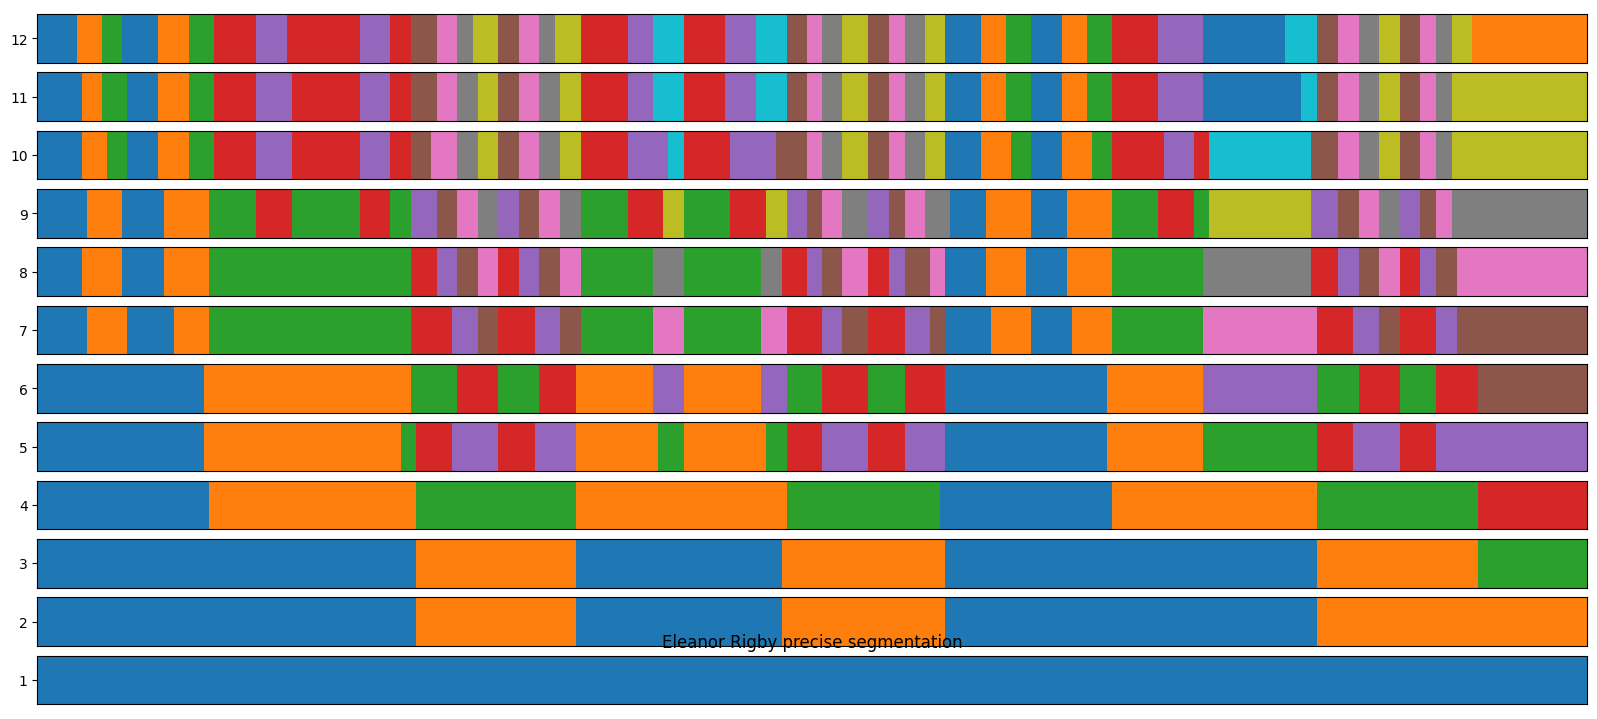

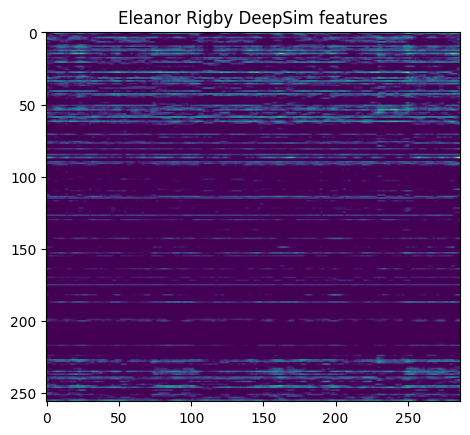

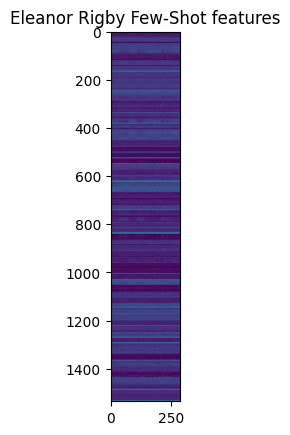

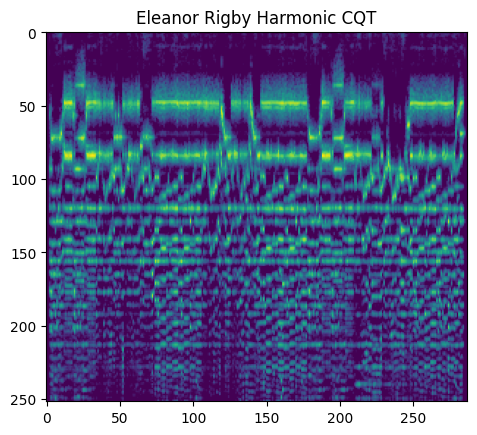

In [3]:
# yaml load config file
with open(config_path, "r") as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

# segment if segmentation information file not provided
if input_seg_path is None:
    print("> Segmenting...")
    if seg_method == "precise":
        segmentation, beat_times, beat_analysis, R, Csync, Msync, Hsync = precise_segmentation(
            audio_filepath=input_audio_path,
            config=config,
            deepsim_model_dir="models/deepsim",
            fewshot_model_dir="models/fewshot",
            use_gpu=use_gpu)
    elif seg_method == "fast":
        import warnings
        warnings.warn("Using fast segmentation. Point similarity and segmentation will be "
                        "based on CQT and MFCC similarity, which may not be very accurate.",
                        stacklevel=2)
        segmentation, beat_times, beat_analysis, R, Csync, Msync, Hsync = fast_segmentation(
            audio_filepath=input_audio_path,
            config=config)
    else:
        raise ValueError("Invalid segmentation method.")

    # Write segmentation information to file
    if output_dir is None:
        output_seg_path = input_audio_path[:-4] + f"_{seg_method}.pkl"
    else:
        output_seg_path = os.path.join(
            output_dir,
            os.path.basename(input_audio_path[:-4]) + f"_{seg_method}.pkl")
    with open(output_seg_path, "wb") as f:
        pickle.dump([segmentation, beat_times, beat_analysis, R, Csync, Msync, Hsync], f)
else:
    print("> Loading segmentation information...")
    # load already computed segmentation information
    with open(input_seg_path, "rb") as f:
        segmentation, beat_times, beat_analysis, R, Csync, Msync, Hsync = pickle.load(f)

# Save useful segmentation-related plots
print("> Saving segmentation plots...")
if plot:
    save_useful_plots(
        output_dir=output_dir,
        output_name=os.path.basename(input_audio_path[:-4]),
        seg_method=seg_method,
        segmentation=segmentation,
        Csync=Csync,
        Msync=Msync,
        Hsync=Hsync)


In [4]:
# Format and quantize structure representation
segmentation_beats = structure_time_to_beats(
    segmentation=segmentation,
    beat_times=beat_times)
segmentation_n_measures, downbeat_times, downbeat_beats, n_measure_beats = quantize_to_measures(
    segmentation_beats=segmentation_beats,
    n_measures=config["min_measure"],
    beat_analysis=beat_analysis,
    beat_times=beat_times)
segmentation_n_measures_unique = get_unique_segments(segmentation_beats)

### Identification

In [5]:
patterns = common_patterns(
    Csync=Csync,
    Msync=Msync,
    Hsync=Hsync,
    length=config["pattern_length"],
    percentile=config["similarity_percentile"])

In [6]:
# Get cross-segment points
cross_points = cross_segment_points(
    segmentation=segmentation_n_measures_unique,
    quantization=config["min_measure"],
    beats_in_measure=int(np.max(beat_analysis[:, 1])),
    patterns=patterns,
    point_types="all")


In [7]:
intra_points = intra_segment_points(
    segmentation=segmentation_n_measures,
    levels_list=config["intra_levels_list"],
    min_d_len=config["pattern_length"],
    patterns=patterns,
    beats_in_measure=int(np.max(beat_analysis[:, 1])))
print(intra_points)

[([17, 29], 0.5434733890027744), ([13, 29], 0.7295854196860357), ([42, 62], 0.4909294218263199), ([79, 95], 0.7503893272277483), ([123, 143], 0.5407678390750982), ([150, 166], 0.6019297062540764), ([153, 169], 0.6653319882738896), ([159, 175], 0.601674411183264), ([183, 199], 0.48641268175673197), ([190, 206], 0.5780899330312739), ([255, 271], 0.7642438528797028), ([260, 276], 0.5244759468142522), ([17, 29], 0.5434733890027744), ([13, 29], 0.7295854196860357), ([42, 62], 0.4909294218263199), ([79, 95], 0.7503893272277483), ([123, 143], 0.5407678390750982), ([150, 166], 0.6019297062540764), ([153, 169], 0.6653319882738896), ([159, 175], 0.601674411183264), ([183, 199], 0.48641268175673197), ([190, 206], 0.5780899330312739), ([255, 271], 0.7642438528797028), ([260, 276], 0.5244759468142522), ([17, 29], 0.5434733890027744), ([13, 29], 0.7295854196860357), ([42, 62], 0.4909294218263199), ([183, 199], 0.48641268175673197), ([190, 206], 0.5780899330312739), ([17, 29], 0.5434733890027744), ([

In [15]:
transitions, similarities = get_transitions(
    cross_points+intra_points,
    patterns.shape[0],
    type="ideal",
    neighbors=True)

In [16]:
print(len(similarities.keys()))

148


In [17]:
points = []
for current, value in transitions.items():
    for candidate in value:
        if (abs(current-candidate)) % (int(max([b[1] for b in beat_analysis]))) == 0:
            points.append((current, candidate))
print(len(points))

119


In [18]:

beat_list = less_transitions_algorithm(
    transitions=transitions,
    similarities=similarities,
    target_beats=get_target_n_beats(target_seconds, beat_analysis),
    total_beats=patterns.shape[0],
    beat_analysis=beat_analysis)

In [19]:
print(beat_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287]
